<a href="https://colab.research.google.com/github/c-grantham/Carbon-Flux-LSTM/blob/main/climate_Arid.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import wandb
WANDB_API_KEY = '921fe29739dc11799063c217996fedaa02caf2f0'
wandb.login()

/usr/local/lib/python3.12/dist-packages/notebook/notebookapp.py:191: SyntaxWarning: invalid escape sequence '\/'
  | |_| | '_ \/ _` / _` |  _/ -_)


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: calgrantham (calgrantham-personal) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


True

In [ ]:
# Environment setup
import os
import pandas as pd
import numpy as np
import torch
from glob import glob
from datetime import datetime
from google.colab import drive
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer


# Mount Google Drive to Colab
drive.mount('/content/drive')

# Path to folder where data is stored (change as needed)
data_dir = '/content/drive/My Drive/Carbon Fluxes/Fluxnet_cleaned/'

Mounted at /content/drive


In [ ]:
# Return the climate zone given a row of binary input
def assign_climate_zone(row):
    if row["climate_Arctic"] == 1:
        return "Arctic"
    elif row["climate_Continental"] == 1:
        return "Continental"
    elif row["climate_Temperate"] == 1:
        return "Temperate"
    elif row["climate_Tropical"] == 1:
        return "Tropical"
    elif row["climate_Arid"] == 1:
        return "Arid"
    else:
        return ""

dynamic_cols = [
  "Lai",
  # "Lat", Reduces generalization
  # "Lon", Reduces generalization
  # "H", Exclude flux variables
  # "LE", Exclude flux variables
  "SWC",
  # "G_F_MDS", Does not represent underlying environmental drivers
  "TA_ERA",
  "SW_IN_ERA",
  "VPD_ERA",
  "PA_ERA",
  "P_ERA",
  "WS_ERA",
  "USTAR",
  "CO2_F_MDS",
  # "SW_IN_POT" Highly correlated to SW_IN_ERA and redundant
]

# Takes string path as input and loads all csv files into a df
def access_files(path: str, climate_zone: str):
  csv_files = glob(os.path.join(path, "*.csv"))
  if csv_files:
    print(f"Found {len(csv_files)} files.\n")
  else:
    print("No files found.")
    return pd.DataFrame() # Return empty DataFrame if no files found

  # Read all csv files into a list of DataFrames
  dataframes = []
  # Store site name as key and DataFrame as value
  sites_data = {}
  for file_path in csv_files:
    df = pd.read_csv(file_path)
    df["climate_Zone"] = df.apply(assign_climate_zone, axis=1)
    if climate_zone in df["climate_Zone"].unique():
        site_name = os.path.basename(file_path).replace(".csv", "")
        sites_data[site_name] = df
  return sites_data

# Drop unwanted inconsistent columns
def drop_columns(data, cols_to_drop):
    # data: dict of site_name -> DataFrame
    # cols_to_drop: list of columns to remove

    # Find columns that are all NaN in at least one site
    all_nan_cols = set()
    for site_name, df in data.items():
        all_nan_cols.update(df.columns[df.isna().all()])

    # Combine user-provided columns with all-NaN columns
    cols_to_drop = list(set(cols_to_drop) | all_nan_cols)
    print(f"Dropping the following columns: {cols_to_drop}")

    # Drop the unwanted columns if they exist
    for site_name, df in data.items():
        data[site_name] = df.drop(columns=[col for col in cols_to_drop if col in df.columns])
    return data

# Filter out desired climate zone
def filter_climate(df, zone):
  filter_df = df[df["climate_Zone"] == zone]
  print(f"Found {len(filter_df)} samples of climate zone {zone}.\n")
  return filter_df

# Combine all sites into a df and handle missing values

# Drop samples with missing targets, impute missing dynamic variables, fill categorical features with values from the same site

def combine_sites(data, dynamic_cols, limit=None):
  all_sites = []
  i = 0
  print("Processing the following sites:")

  # Iterate through all sites, with an optional limit
  for site_name, df in data.items():
    if limit is not None and i >= limit:
        break
    print(f"- {site_name}")
    df = df.copy()
    # Iterate through numeric columns within site
    for col in dynamic_cols:
        if col in df.columns:
            # Fill entire column with simple imputer
            imputer = SimpleImputer(missing_values = np.nan, strategy ='mean')
            imputed_values = imputer.fit_transform(df[[col]])
            if imputed_values.size > 0:
                df[col] = imputed_values.ravel()

    all_sites.append(df)
    i += 1
  df_all = pd.concat(all_sites, ignore_index=True)
  return df_all.copy()

# Convert date to separate day, month, year features
def date_conv(df):
  # Convert to datetime safely
  df = df.copy()  # Avoid SettingWithCopyWarning
  df["date"] = pd.to_datetime(df["date"], format='%Y_%m_%d', errors="coerce")

  # Check if conversion succeeded
  if not pd.api.types.is_datetime64_any_dtype(df["date"]):
    raise TypeError("Column 'date' could not be converted to datetime.")

  # Extract date components
  df["day"] = df["date"].dt.dayofyear
  df["month"] = df["date"].dt.month
  df["year"] = df["date"].dt.year

  # Desired order: new time columns first, followed by the rest
  time_columns = ["name", "date", "day", "month", "year"]
  other_columns = [col for col in df.columns if col not in time_columns]
  # Reorder
  df = df[time_columns + other_columns]
  return df

In [ ]:
# Load data into dict name:data pair
sites = access_files(data_dir, "Arid")

sites = drop_columns(sites, ["Lat", "Lon", "PPFD_IN", "PPFD_OUT", "RECO_NT_VUT_REF", "RECO_DT_VUT_REF", "GPP_DT_VUT_REF", "GPP_NT_VUT_REF", "H", "LE", "G_F_MDS", "SW_IN_POT"])

all_sites = combine_sites(sites, dynamic_cols, 1)

arid_sites = date_conv(all_sites)
print(arid_sites.head())

arid_sites = arid_sites.reset_index(drop=True)
nan_summary = arid_sites.isna().sum().sort_values(ascending=False)
print("\nNaN Summary:\n", nan_summary[nan_summary > 0])  # Only show columns with NaNs

Found 201 files.

Dropping the following columns: ['SWC', 'PPFD_IN', 'Lat', 'H', 'RECO_NT_VUT_REF', 'PPFD_OUT', 'LE', 'GPP_NT_VUT_REF', 'RECO_DT_VUT_REF', 'GPP_DT_VUT_REF', 'SW_IN_POT', 'Lon', 'G_F_MDS', 'CO2_F_MDS']
Processing the following sites:
- US-Atq
     name       date  day  month  year    Lai  NEE_VUT_REF  TA_ERA  SW_IN_ERA  \
0  US-Atq 2003-02-06   37      2  2003  0.200    -0.588776 -21.016      2.637   
1  US-Atq 2003-02-07   38      2  2003  0.225    -0.710383 -18.062      5.058   
2  US-Atq 2003-02-08   39      2  2003  0.250    -0.701398 -19.202      1.573   
3  US-Atq 2003-02-09   40      2  2003  0.275    -0.692435 -19.181      2.121   
4  US-Atq 2003-02-10   41      2  2003  0.300    -0.676375 -20.095      6.663   

   VPD_ERA  ...  pft_SAV  pft_SNO  pft_WET  pft_WSA  climate_Arctic  \
0   0.0133  ...        0        0        1        0               1   
1   0.0216  ...        0        0        1        0               1   
2   0.0074  ...        0        0        1

In [ ]:
# This line checks if GPU is available
DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [ ]:
# GPP, RECO, and NEE targets
targets = [
    # "GPP_NT_VUT_REF",
    # "GPP_DT_VUT_REF",
     "NEE_VUT_REF",
    # "RECO_NT_VUT_REF",
    #"RECO_DT_VUT_REF"
]

inputs_onehot = [
    "pft_MF",
    "pft_CRO",
    "pft_CSH",
    "pft_DBF",
    "pft_EBF",
    "pft_ENF",
    "pft_GRA",
    "pft_OSH",
    "pft_SAV",
    "pft_SNO",
    "pft_WET",
    "pft_WSA",
    "climate_Arctic",
    "climate_Continental",
    "climate_Temperate",
    "climate_Tropical",
    "climate_Arid"
]

# All inputs excluding targets, name, inconsistent, and unimportant features
inputs_cont = [col for col in arid_sites.columns if col not in targets + inputs_onehot + ['name', 'date', 'climate_Zone']]

# Split the data FIRST (using the raw data)
split_1 = int(len(arid_sites) * 0.7)
split_2 = int(len(arid_sites) * 0.85)

train_data = arid_sites.iloc[:split_1]
val_data = arid_sites.iloc[split_1:split_2]
test_data = arid_sites.iloc[split_2:]

# Extract features and targets for each split
x_train_cont = train_data[inputs_cont].values
x_val_cont = val_data[inputs_cont].values
x_test_cont = test_data[inputs_cont].values

x_train_onehot = train_data[inputs_onehot].values
x_val_onehot = val_data[inputs_onehot].values
x_test_onehot = test_data[inputs_onehot].values

y_train = train_data[targets].values
y_val = val_data[targets].values
y_test = test_data[targets].values

# Fit scaler ONLY on training data
scaler = StandardScaler()
x_train_scaled_cont = scaler.fit_transform(x_train_cont)

# Transform validation and test data using parameters from training data
x_val_scaled_cont = scaler.transform(x_val_cont)
x_test_scaled_cont = scaler.transform(x_test_cont)

# Combine scaled continuous and one-hot features
x_train = np.concatenate([x_train_scaled_cont, x_train_onehot], axis=1)
x_val = np.concatenate([x_val_scaled_cont, x_val_onehot], axis=1)
x_test = np.concatenate([x_test_scaled_cont, x_test_onehot], axis=1)

In [ ]:
import torch
from torch.utils.data import TensorDataset, DataLoader
import numpy as np

seq_length = 30  # Number of past time steps used as input
horizon = 1       # Number of future time steps to predict
batch_size = 64

def reshaper(x, y, seq_length, horizon):
    """
    Convert time series into sliding windows for LSTM input.

    Args:
        x: 2D array of shape (num_timesteps, num_features)
        y: 1D or 2D array of targets, shape (num_timesteps,) or (num_timesteps, num_targets)
        seq_length: number of past timesteps used as input
        horizon: number of future timesteps to predict (horizon >= 1)

    Returns:
        x_seq: tensor of shape (num_sequences, seq_length, num_features)
        y_seq: tensor of shape (num_sequences, horizon, num_targets)
    """
    x_seq, y_seq = [], []

    for i in range(len(x) - seq_length - (horizon - 1)):
        # Slice past sequence
        x_seq.append(x[i : i + seq_length])

        # Slice future targets; preserves horizon dimension even if horizon=1
        y_seq.append(y[i + seq_length : i + seq_length + horizon])

    # Convert lists to numpy arrays
    x_seq = np.array(x_seq)
    y_seq = np.array(y_seq)

    # Convert to PyTorch tensors
    return torch.tensor(x_seq, dtype=torch.float32), torch.tensor(y_seq, dtype=torch.float32)

# --- Prepare train/val/test sequences ---
x_train_seq, y_train_seq = reshaper(x_train, y_train, seq_length, horizon)
x_val_seq, y_val_seq     = reshaper(x_val, y_val, seq_length, horizon)
x_test_seq, y_test_seq   = reshaper(x_test, y_test, seq_length, horizon)

print("Shapes after reshaping:")
print("x_train:", x_train_seq.shape, "y_train:", y_train_seq.shape)
print("x_val:  ", x_val_seq.shape, "y_val:  ", y_val_seq.shape)
print("x_test: ", x_test_seq.shape, "y_test: ", y_test_seq.shape)

# --- Wrap sequences into TensorDataset and DataLoader ---
train_dataset = TensorDataset(x_train_seq, y_train_seq)
val_dataset   = TensorDataset(x_val_seq, y_val_seq)
test_dataset  = TensorDataset(x_test_seq, y_test_seq)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader   = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader  = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


Shapes after reshaping:
x_train: torch.Size([1479, 30, 28]) y_train: torch.Size([1479, 1, 1])
x_val:   torch.Size([293, 30, 28]) y_val:   torch.Size([293, 1, 1])
x_test:  torch.Size([294, 30, 28]) y_test:  torch.Size([294, 1, 1])


In [ ]:
import torch.nn as nn

class LSTMCarbonFlux(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_targets, num_layers, seq_len, dropout_rate):
        super(LSTMCarbonFlux, self).__init__()

        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.output_size = output_size
        self.num_targets = num_targets
        self.seq_len = seq_len

        # LSTM Layer without built-in dropout
        self.lstm = nn.LSTM(
            input_size=input_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=True,
            dropout=0  # No built-in dropout
        )

        # Dropout layer applied to LSTM outputs
        self.dropout = nn.Dropout(dropout_rate)

        # Fully connected layer
        self.fc = nn.Linear(hidden_size, output_size * num_targets)

    def forward(self, x):
        # LSTM forward pass
        lstm_out, _ = self.lstm(x)  # shape: (batch_size, seq_len, hidden_size)

        # Apply dropout to ALL LSTM outputs
        lstm_out = self.dropout(lstm_out)

        # Take the last timestep
        last_timestep = lstm_out[:, -1, :]  # shape: (batch_size, hidden_size)

        # Fully connected layer
        pred = self.fc(last_timestep)

        # Reshape
        pred = pred.view(-1, self.output_size, self.num_targets)

        return pred

In [ ]:
feature_cols = inputs_cont + inputs_onehot
print("Features used for this run:", feature_cols)

wandb.init(
    project="carbon_flux_NEE_onesite",   # the name of your project
    config={
        "climate": "Arctic",
        "sites": 1,
        "output_size": 1,
        "targets": "NEE_VUT_REF",
        "input_size": x_train_seq.shape[2],
        "features": feature_cols,
        "hidden_size": 256,
        "num_layers": 1,
        "seq_length": seq_length,
        "batch_size": 64,
        "learning_rate": 0.00179,
        "epochs": 10,
        "loss_function": "MSE",
        "optimizer": "Adam",
        "early_stopping_patience": 5,
        "early_stopping_min_delta": 0.0001,
        "early_stopping_restore_best": True,
        "dropout_rate": 0.4
    }
)
config = wandb.config  # access your config later in the code

Features used for this run: ['day', 'month', 'year', 'Lai', 'TA_ERA', 'SW_IN_ERA', 'VPD_ERA', 'PA_ERA', 'P_ERA', 'WS_ERA', 'USTAR', 'pft_MF', 'pft_CRO', 'pft_CSH', 'pft_DBF', 'pft_EBF', 'pft_ENF', 'pft_GRA', 'pft_OSH', 'pft_SAV', 'pft_SNO', 'pft_WET', 'pft_WSA', 'climate_Arctic', 'climate_Continental', 'climate_Temperate', 'climate_Tropical', 'climate_Arid']


In [ ]:
config = wandb.config  # already set after wandb.init()

# Define model hyperparameters from wandb config
input_size  = config.input_size        # number of features per timestep
hidden_size = config.hidden_size       # LSTM hidden state size
output_size = config.output_size       # forecast horizon
num_targets = y_train_seq.shape[1]     # keep as-is, depends on your targets
num_layers  = config.num_layers
seq_len     = config.seq_length
dropout_rate= config.dropout_rate

model = LSTMCarbonFlux(
    input_size=input_size,
    hidden_size=hidden_size,
    output_size=output_size,
    num_targets=num_targets,
    num_layers=num_layers,
    seq_len=seq_len,
    dropout_rate=dropout_rate
)

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=config.learning_rate)

scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=1)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

LSTMCarbonFlux(
  (lstm): LSTM(28, 256, batch_first=True)
  (dropout): Dropout(p=0.4, inplace=False)
  (fc): Linear(in_features=256, out_features=1, bias=True)
)

✓ New best loss: 0.5946. Patience reset.
Epoch 1/10 | Train: 0.2606 | Val: 0.5946
✓ New best loss: 0.1872. Patience reset.
Epoch 2/10 | Train: 0.1881 | Val: 0.1872
✗ No improvement (1/5). Best: 0.1872
Epoch 3/10 | Train: 0.1458 | Val: 0.2023
✗ No improvement (2/5). Best: 0.1872
Epoch 4/10 | Train: 0.1323 | Val: 0.2014
✓ New best loss: 0.1785. Patience reset.
Epoch 5/10 | Train: 0.1164 | Val: 0.1785
✓ New best loss: 0.1354. Patience reset.
Epoch 6/10 | Train: 0.1001 | Val: 0.1354
✗ No improvement (1/5). Best: 0.1354
Epoch 7/10 | Train: 0.1002 | Val: 0.1478
✗ No improvement (2/5). Best: 0.1354
Epoch 8/10 | Train: 0.0986 | Val: 0.1998
✗ No improvement (3/5). Best: 0.1354
Epoch 9/10 | Train: 0.0876 | Val: 0.1493
✗ No improvement (4/5). Best: 0.1354
Epoch 10/10 | Train: 0.0805 | Val: 0.1525


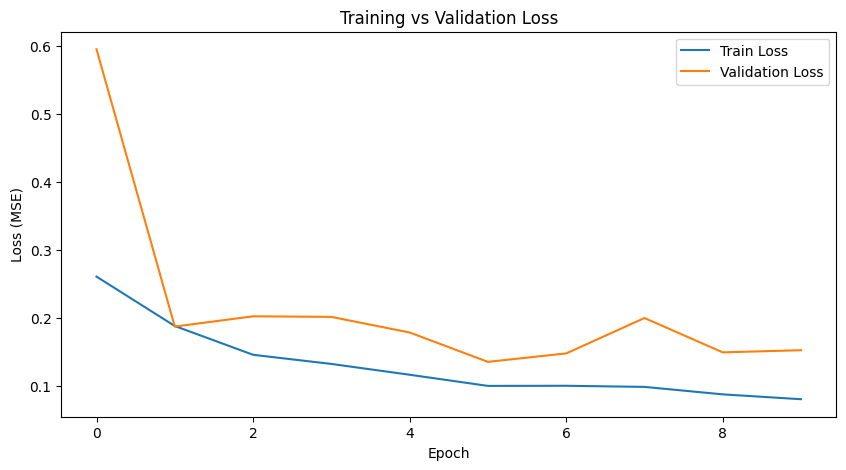

['/content/wandb/run-20250912_155049-2wafshxp/files/final_model.pth']

In [ ]:
import matplotlib.pyplot as plt
import copy

# Early stopping parameters (defined locally, not in W&B config)
patience = config.early_stopping_patience
min_delta = config.early_stopping_min_delta

# Use a fixed variable for the print statement that never changes
original_num_epochs = config.epochs
num_epochs = config.epochs  # This can be used for the loop
train_losses, val_losses = [], []

# Early stopping variables - ENHANCED
best_val_loss = float('inf')
epochs_no_improve = 0
early_stop = False
best_model_weights = None
# --- NEW: Look-back window parameters ---
look_back_window = 5  # Only reset patience if we beat the best from 5 epochs ago
best_val_loss_in_window = float('inf')

for epoch in range(num_epochs):
    if early_stop:
        print(f"Early stopping triggered at epoch {epoch+1}")
        break

    # -------- Training --------
    model.train()
    train_loss = 0.0
    for xb, yb in train_loader:
        xb, yb = xb.to(device), yb.to(device)
        optimizer.zero_grad()
        preds = model(xb)
        loss = criterion(preds, yb)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    train_loss /= len(train_loader)
    train_losses.append(train_loss)

    # -------- Validation --------
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for xb, yb in val_loader:
            xb, yb = xb.to(device), yb.to(device)
            val_loss += criterion(model(xb), yb).item()
    val_loss /= len(val_loader)
    val_losses.append(val_loss)

    scheduler.step(val_loss)

    # -------- SIMPLE & CLEAR Early stopping check --------
    # Check if this is a meaningful new best loss
    if val_loss < best_val_loss - min_delta:
        # This is a meaningful improvement!
        best_val_loss = val_loss
        epochs_no_improve = 0  # RESET the patience counter
        best_model_weights = copy.deepcopy(model.state_dict())
        # Save and upload the best model
        torch.save(model.state_dict(), "best_model.pth")
        wandb.save("best_model.pth")
        print(f"✓ New best loss: {val_loss:.4f}. Patience reset.")
    else:
        # This is NOT a meaningful improvement.
        epochs_no_improve += 1
        print(f"✗ No improvement ({epochs_no_improve}/{patience}). Best: {best_val_loss:.4f}")

    # Check if we should trigger early stopping
    if epochs_no_improve >= patience:
        early_stop = True
        print(f"--> Early stopping triggered!")

    # -------- Log scalars --------
    wandb.log({"train_loss": train_loss, "val_loss": val_loss}, step=epoch+1)
    print(f"Epoch {epoch+1}/{num_epochs} | Train: {train_loss:.4f} | Val: {val_loss:.4f}")

# --- RESTORE THE BEST WEIGHTS IF EARLY STOPPING HAPPENED ---
if early_stop and best_model_weights is not None:
    print(f"Restoring best model weights from epoch with val_loss: {best_val_loss:.4f}")
    model.load_state_dict(best_model_weights)

# -------- Plot & log loss curve - COMPLETELY UNCHANGED --------
fig, ax = plt.subplots(figsize=(10,5))
ax.plot(train_losses, label="Train Loss")
ax.plot(val_losses, label="Validation Loss")
ax.set_xlabel("Epoch")
ax.set_ylabel("Loss (MSE)")
ax.set_title("Training vs Validation Loss")
ax.legend()
plt.show()

fig.savefig("loss_curve.png")
# FIXED: Log the image with the actual final epoch count, not the original target
actual_epochs_completed = len(train_losses)
wandb.log({"loss_curve_img": wandb.Image("loss_curve.png")}, step=actual_epochs_completed)
plt.close(fig)

# -------- Save final model - COMPLETELY UNCHANGED UPLOAD LOGIC --------
torch.save(model.state_dict(), "final_model.pth")
wandb.save("final_model.pth")

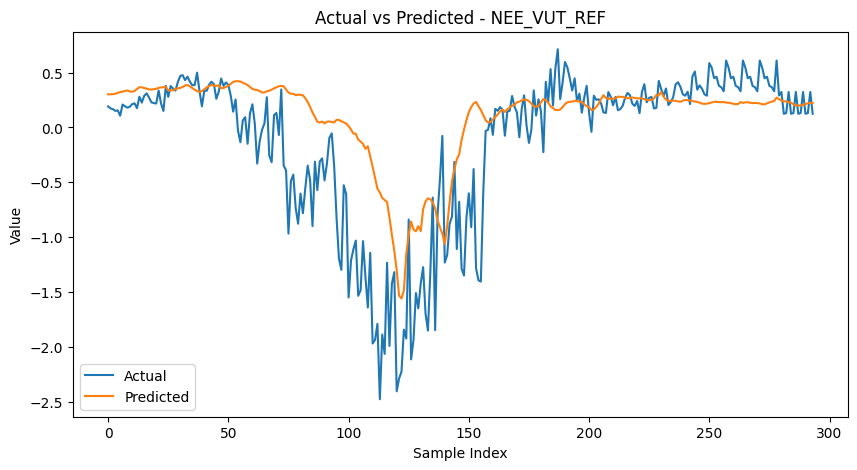

In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np
import matplotlib.pyplot as plt

model.load_state_dict(torch.load("best_model.pth"))
model.eval()

all_preds, all_targets = [], []

with torch.no_grad():
    for xb, yb in test_loader:
        xb, yb = xb.to(device), yb.to(device)
        preds = model(xb)
        all_preds.append(preds.cpu().numpy())
        all_targets.append(yb.cpu().numpy())

all_preds = np.concatenate(all_preds, axis=0)
all_targets = np.concatenate(all_targets, axis=0)
all_preds_flat = all_preds.reshape(-1, all_preds.shape[-1])
all_targets_flat = all_targets.reshape(-1, all_targets.shape[-1])

target_names = [item[:-8] for item in targets] if len(targets) > 1 else [targets[0]]
eval_step = num_epochs + 1  # all evaluation logs at this step

if all_targets_flat.shape[1] == 1:
    y_true = all_targets_flat.flatten()
    y_pred = all_preds_flat.flatten()
    name = target_names[0]

    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)

    # In your evaluation code:
    wandb.log({
        f"{name}_MSE": mse,
        f"{name}_RMSE": rmse,
        f"{name}_MAE": mae,
        f"{name}_R2": r2,
        # Add these aggregated metrics with consistent names
        "final_MSE": mse,
        "final_RMSE": rmse,
        "final_MAE": mae,
        "final_R2": r2
    }, step=eval_step)

    fig, ax = plt.subplots(figsize=(10,5))
    ax.plot(y_true, label="Actual")
    ax.plot(y_pred, label="Predicted")
    ax.set_title(f"Actual vs Predicted - {name}")
    ax.set_xlabel("Sample Index")
    ax.set_ylabel("Value")
    ax.legend()
    plt.show()
    wandb.log({f"Actual_vs_Predicted_{name}": wandb.Image(fig)}, step=eval_step)
    plt.close(fig)
else:
    total_mse = total_rmse = total_mae = total_r2 = 0
    wandb_metrics = {}

    for i, name in enumerate(target_names):
        y_true = all_targets_flat[:, i]
        y_pred = all_preds_flat[:, i]

        mse = mean_squared_error(y_true, y_pred)
        rmse = np.sqrt(mse)
        mae = mean_absolute_error(y_true, y_pred)
        r2 = r2_score(y_true, y_pred)

        total_mse += mse
        total_rmse += rmse
        total_mae += mae
        total_r2 += r2

        wandb_metrics[f"{name}_MSE"] = mse
        wandb_metrics[f"{name}_RMSE"] = rmse
        wandb_metrics[f"{name}_MAE"] = mae
        wandb_metrics[f"{name}_R2"] = r2

        fig, ax = plt.subplots(figsize=(10,5))
        ax.plot(y_true, label="Actual")
        ax.plot(y_pred, label="Predicted")
        ax.set_title(f"Actual vs Predicted - {name}")
        ax.set_xlabel("Sample Index")
        ax.set_ylabel("Value")
        ax.legend()
        plt.show()
        wandb.log({f"Actual_vs_Predicted_{name}": wandb.Image(fig)}, step=eval_step)
        plt.close(fig)

    num_targets = len(target_names)
    wandb_metrics.update({
        "Average_MSE": total_mse / num_targets,
        "Average_RMSE": total_rmse / num_targets,
        "Average_MAE": total_mae / num_targets,
        "Average_R2": total_r2 / num_targets
    })
    wandb.log(wandb_metrics, step=eval_step)


In [ ]:
wandb.finish()


NEE_VUT_REF_MAE,▁
NEE_VUT_REF_MSE,▁
NEE_VUT_REF_R2,▁
NEE_VUT_REF_RMSE,▁
final_MAE,▁
final_MSE,▁
final_R2,▁
final_RMSE,▁
train_loss,█▅▄▃▂▂▂▂▁▁
val_loss,█▂▂▂▂▁▁▂▁▁
NEE_VUT_REF_MAE,0.34221


Error Skewness: -1.2269374132156372
Error Kurtosis: 0.8851265907287598


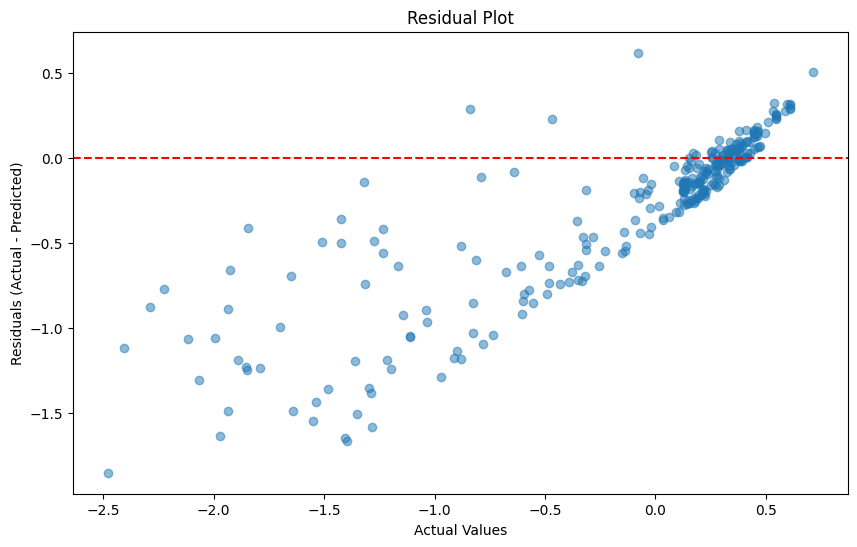

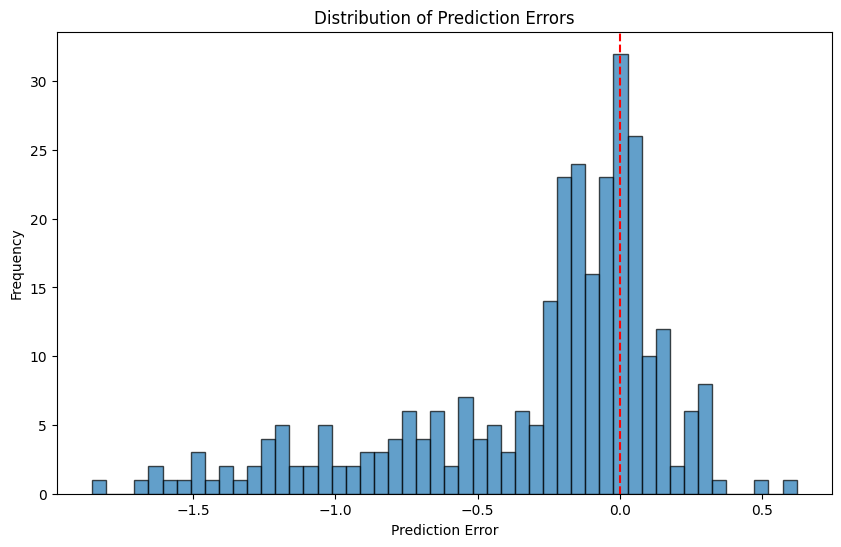

'\nwandb.log({\n    "Error_Skewness": error_skew,\n    "Error_Kurtosis": error_kurtosis\n}, step=eval_step)\n'

In [ ]:
# Calculate residuals
residuals = y_true - y_pred


from scipy.stats import skew, kurtosis

error_skew = skew(residuals)
error_kurtosis = kurtosis(residuals)
print(f"Error Skewness: {error_skew}")
print(f"Error Kurtosis: {error_kurtosis}")

# Create residual plot
plt.figure(figsize=(10, 6))
plt.scatter(y_true, residuals, alpha=0.5)
plt.axhline(y=0, color='r', linestyle='--') # Perfect prediction line
plt.xlabel('Actual Values')
plt.ylabel('Residuals (Actual - Predicted)')
plt.title('Residual Plot')
plt.show()

# Log to W&B
#wandb.log({"Residual_Plot": wandb.Image(plt)}, step=eval_step)
#plt.close()

plt.figure(figsize=(10, 6))
plt.hist(residuals, bins=50, edgecolor='black', alpha=0.7)
plt.axvline(x=0, color='r', linestyle='--')
plt.xlabel('Prediction Error')
plt.ylabel('Frequency')
plt.title('Distribution of Prediction Errors')
plt.show()

# Log to W&B
#wandb.log({"Error_Distribution": wandb.Image(plt)}, step=eval_step)
#plt.close()

'''
wandb.log({
    "Error_Skewness": error_skew,
    "Error_Kurtosis": error_kurtosis
}, step=eval_step)
'''

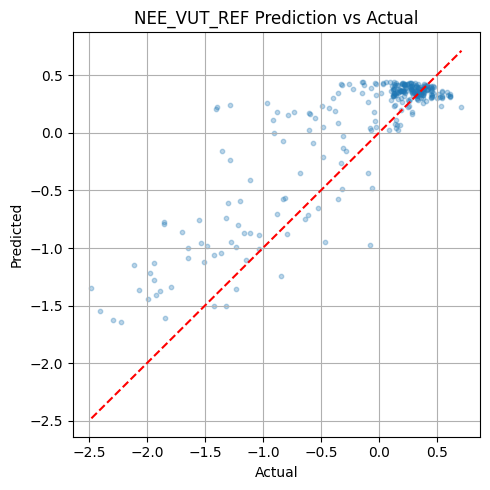

In [ ]:
import matplotlib.pyplot as plt

for i, name in enumerate(target_names):
    plt.figure(figsize=(5, 5))
    plt.scatter(all_targets_flat[:, i], all_preds_flat[:, i], alpha=0.3, s=10)
    plt.plot([all_targets_flat[:, i].min(), all_targets_flat[:, i].max()],
             [all_targets_flat[:, i].min(), all_targets_flat[:, i].max()], 'r--')
    plt.xlabel("Actual")
    plt.ylabel("Predicted")
    plt.title(f"{name} Prediction vs Actual")
    plt.grid(True)
    plt.tight_layout()
    plt.show()
